# Triangle Signal Generator

A *triangle wave* is a periodic waveform that linearly ramps between two  values. 

In [1]:
import magma as m
m.set_mantle_target('ice40')

In [2]:
import mantle

def DefineTriangle(n):
    T = m.Bits(n)
    class _Triangle(m.Circuit):
        name = f'Triangle{n}'
        IO  = ['I', m.In(T), 'O', m.Out(T)]
    
        @classmethod
        def definition(io):
            invert = mantle.Invert(n)
            mux = mantle.Mux(2, n)
            m.wire( mux( io.I, invert(io.I), io.I[n-1] ), io.O )
    return _Triangle

def Triangle(n):
    return DefineTriangle(n)()

import lattice ice40
import lattice mantle40


In [3]:
from loam.boards.icestick import IceStick

N = 8

icestick = IceStick()
icestick.Clock.on()
for i in range(N):
    icestick.J3[i].output().on()

main = icestick.main()  
counter = mantle.Counter(32)
sawtooth = counter.O[8:8+N]
tri = Triangle(N)
m.wire( tri(sawtooth), main.J3 )
m.EndDefine()

In [4]:
m.compile('build/triangle', main)

compiling FullAdder
compiling Add32_COUT
compiling Register32
compiling Counter32_COUT
compiling Invert8
compiling Mux2
compiling Mux2x8
compiling Triangle8
compiling main


In [5]:
%%bash
cd build
cat triangle.pcf
yosys -q -p 'synth_ice40 -top main -blif triangle.blif' triangle.v
arachne-pnr -q -d 1k -o triangle.txt -p triangle.pcf triangle.blif 
icepack triangle.txt triangle.bin
iceprog triangle.bin

set_io J3[7] 44
set_io J3[6] 45
set_io J3[5] 47
set_io J3[4] 48
set_io J3[3] 56
set_io J3[2] 60
set_io J3[1] 61
set_io J3[0] 62
set_io CLKIN 21


init..
cdone: high
reset..
cdone: low
flash ID: 0x20 0xBA 0x16 0x10 0x00 0x00 0x23 0x51 0x73 0x10 0x23 0x00 0x35 0x00 0x35 0x06 0x06 0x15 0x43 0xB6
file size: 32220
erase 64kB sector at 0x000000..
programming..
reading..
VERIFY OK
cdone: high
Bye.


We can wire up the GPIO pins to a logic analyzer to verify that our circuit produces the correct triangle waveform.

![](images/triangle.png)

We can also use Saleae's [export data](https://support.saleae.com/hc/en-us/articles/115005986806-Saving-Loading-and-Exporting-Data) feature to output a [csv file](data/triangle-capture.csv). We'll load this data into Python and plot the results.

In [6]:
import csv
import magma as m
with open("data/triangle-capture.csv") as triangle_capture_csv:
    csv_reader = csv.reader(triangle_capture_csv)
    next(csv_reader, None)  # skip the headers
    rows = [row for row in csv_reader]
timestamps = [float(row[0]) for row in rows]
values = [m.bitutils.seq2int(tuple(int(x) for x in row[1:])) for row in rows]

**TODO**: Why do we have this little bit of jitter? Logic analyzer is running at 25 MS/s, 3.3+ Volts for 1s

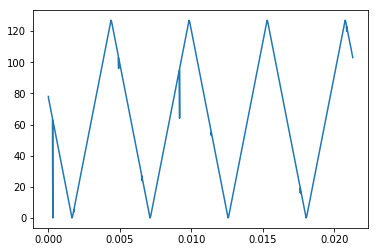

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(timestamps[:1000], values[:1000], "-")